<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/RNN_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on this:
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

#The data

In [6]:
import pandas as pd
import numpy as np

In [7]:
#import csv file as dataframe (from GitHub repo)

url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [8]:
# remove columns with uninformative information (AssignmentId, WorkerId, recAgnPairId, recImgPairId)
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
df = df.drop(columns=uninformative_cols)
df = df[df.memType != 'retold']
df 


,WorkTimeInSeconds,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,memType,mostSurprising,openness,similarity,similarityReason,story,stressful,summary,timeSinceEvent
0,1641,25.0,man,white,1.0,1.0,NaN,3.0,4.499810,attending a show,imagined,when I got concert tickets,0.000,3.0,"I've been to a couple concerts, but not many.","Concerts are my most favorite thing, and my bo...",1.0,My boyfriend and I went to a concert together ...,90.0
1,1245,25.0,woman,white,1.0,1.0,3.0,4.0,4.499810,a concert.,recalled,we saw the beautiful sky.,1.000,NaN,NaN,"The day started perfectly, with a great drive ...",1.0,My boyfriend and I went to a concert together ...,90.0
2,1159,35.0,woman,black,1.0,1.0,NaN,4.0,5.010635,my sister having her twins a little early,imagined,she went into labor early,0.500,3.0,I am a mother myself,It seems just like yesterday but today makes f...,1.0,My sister gave birth to my twin niece and neph...,150.0
3,500,30.0,woman,white,1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,recalled,finding out they were healthy.,1.000,NaN,NaN,"Five months ago, my niece and nephew were born...",2.0,My sister gave birth to my twin niece and neph...,150.0
4,1074,25.0,man,white,2.0,2.0,NaN,3.0,3.401197,the consequences of going to burning man,imagined,When I don't answer the phone in case I owe th...,0.250,4.0,Because I also have money problems,About a month ago I went to burning man. I was...,4.0,It is always a journey for me to go to burning...,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,926,30.0,woman,other,3.0,5.0,3.0,5.0,5.010635,losing and finding a pet.,recalled,the kitten ran into my arms.,0.125,NaN,NaN,My dog was diagnosed with lymphoma a year ago ...,5.0,"My dog, who had lymphoma, was suffering so I h...",150.0
6850,3044,18.0,woman,asian,4.0,2.0,4.0,2.0,6.345636,about a vacation event worked on,recalled,when i encountered an guy who was really scared,-0.500,NaN,NaN,"Over my vacation from my job, I went to Casper...",5.0,"On vacation, a side job was taken to plan an e...",570.0
6851,1008,35.0,man,asian,1.0,2.0,2.0,4.0,3.044522,my nephew's birthday party,recalled,a lot of people got in the pool.,0.500,NaN,NaN,This event was a birthday party for my nephew....,2.0,This was a birthday party for my nephew that h...,21.0
6852,1462,30.0,man,hisp,1.0,1.0,3.0,3.0,2.639057,my cousin's birthday,recalled,my cousin threw a tantrum in the middle of the...,0.500,NaN,NaN,This event occurred about two weeks ago. I was...,2.0,It was my little cousin's birthday and went to...,14.0


#Text preprocessing

In [9]:
def print_plot(index):
    example = df[df.index == index][['story', 'memType']].values[0]
    if len(example) > 0:
        print(example[0])
        print('memType:', example[1])
print_plot(10)

About a month ago me and my girlfriend went to the zoo. It was an unexpected trip we just decided to go on a random Wednesday. It was a pretty hot day that day considering it was the middle of July. As soon as we got in, we saw that there were some seals to the left of the entrance so we saw them for a few minutes. Then we went to the insect section of the zoo. There were so many of them like spiders, scorpions, also bigger animals like cobras, rattlesnakes stuff like that. Then we saw the elephants. It was pretty interesting because they were in an area that looked like a jungle and off in the distance we heard gorillas grunting. So we walked around until we found the gorillas and around there we also saw other kinds of primates like chimpanzees. We walked around a bit more and we stumbled upon all the other African animals like tigers, lions, giraffes etc. It was actually pretty cool to see the giraffes because one of them got really close to me. Along the way we saw a lot of differe

In [10]:
import re
import nltk 
from nltk.corpus import stopwords 
nltk.download('stopwords')

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['story'] = df['story'].apply(clean_text)
df['story'] = df['story'].str.replace('\d+', '')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#Print it to check if it worked
print_plot(10)

vacation visit southeast asia every years least small tourist town thailand right pattaya beach fairly late one evening decided roam around city take pictures citizens shops nightclubs etc found rather secluded dingy part city wasnt sure eactly get back hotel looking one motorbike tais didnt see looking around group thais probably early s could tell part gang something like thought sure going get robbed beat across small street giving eye sudden tai went waved frantically saw drove pick got back hotel safely pretty shaken knew things going go badly small gang caught city another two weeks still ventured tried lot careful parts ventured really known better quite countries cities safe even though im somewhat used types environments still scary tourists known disappear never show happens fairly often especially countries completely corrupt police force still travel im little careful city go go particular city
memType: imagined


#LSTM Modeling

* Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
* Limit the data set to the top 5,0000 words.
* Set the max number of words in each complaint at 750.

In [12]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 750
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['story'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24496 unique tokens.


In [13]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['story'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5535, 750)


In [14]:
Y = pd.get_dummies(df['memType']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5535, 2)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4428, 750) (4428, 2)
(1107, 750) (1107, 2)


# The model

In [29]:
import keras


model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))

model.add(keras.layers.LSTM(25, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.LSTM(25, dropout=0.2, recurrent_dropout=0.2, return_sequences= True))
model.add(keras.layers.LSTM(25, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
111/111 [==============================] - 268s 2s/step - loss: 0.6936 - accuracy: 0.4957 - val_loss: 0.6721 - val_accuracy: 0.6050
Epoch 2/2
111/111 [==============================] - 267s 2s/step - loss: 0.5470 - accuracy: 0.7413 - val_loss: 0.6542 - val_accuracy: 0.6275


In [30]:
 #model evaluation 
 accr = model.evaluate(X_test,Y_test) 
 print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 8s 228ms/step - loss: 0.6865 - accuracy: 0.6016
Test set
 Loss: 0.686
 Accuracy: 0.602


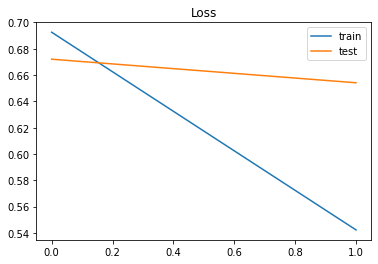

In [31]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

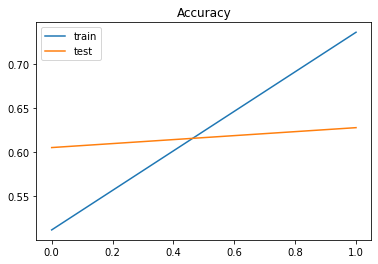

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();